In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re, os
import numpy as np
import xarray as xr
import tensorflow.keras as keras
import datetime
import pdb
import matplotlib.pyplot as plt
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *
import cartopy.crs as ccrs
import seaborn as sns

In [3]:
sns.set_style('darkgrid')

In [101]:
%config InlineBackend.figure_format = 'retina'

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(7)
limit_mem()

In [5]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [6]:
preddir = '/home/rasp/data/myWeatherBench/predictions_C/'
valdir = '/data/stephan/WeatherBench/5.625deg/'

In [7]:
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z', years=slice('2014', '2018', None)).drop('level')
t850_valid = load_test_data(f'{valdir}temperature_850', 't', years=slice('2014', '2018', None)).drop('level')
t2m_valid = xr.open_mfdataset(f'{valdir}2m_temperature/*.nc').sel(time=slice('2014', '2018', None))
valid = xr.merge([z500_valid, t850_valid, t2m_valid]).load()

In [8]:
valid = valid.isel(time=slice(0, None, 12))

In [9]:
rmse_baseline = read_pickle('./rmse.pkl')
rmse_weyn = xr.open_dataset('./weyn_rmse.nc').rename({'z_rmse': "z", 't_rmse': 't'})

## get scores for direct predictions

### Saved predictions

In [ ]:
def get_direct_scores_from_nc(exp_ids, lead_times, func=compute_weighted_rmse, mean_dims=xr.ALL_DIMS):
    scores = []
    for exp_id in tqdm(exp_ids):
        fn = glob(f'{preddir}{exp_id}*.nc')[0]
        preds = xr.open_dataset(fn)
        scores.append(
            func(
                preds, 
                valid,
                mean_dims
            ).load()
        )
    return xr.concat(scores, dim=lead_times)

In [132]:
rmse_direct_era = get_direct_scores_from_nc(['024', '029', '017', '032'], [6, 24, 72, 120])

In [133]:
rmse_direct_era.to_netcdf('./rmse_direct_era.nc')

In [125]:
rmse_direct_pre = get_direct_scores_from_nc(['026', '031', '023', '034'], [6, 24, 72, 120])

In [126]:
rmse_direct_pre.to_netcdf('./rmse_direct_pre.nc')

In [134]:
acc_direct_era = get_direct_scores_from_nc(['024', '029', '017', '032'], [6, 24, 72, 120], compute_weighted_acc)

In [135]:
acc_direct_era.to_netcdf('./acc_direct_era.nc')

In [136]:
acc_direct_pre = get_direct_scores_from_nc(['026', '031', '023', '034'], [6, 24, 72, 120], compute_weighted_acc,
                                           split='test')

In [137]:
acc_direct_pre.to_netcdf('./acc_direct_pre.nc')

### CMIP test scores

In [10]:
def get_direct_scores_from_dg(exp_ids, lead_times, func=compute_weighted_rmse, mean_dims=xr.ALL_DIMS, 
                              train_years=['2014', '2015'], split='train', cmip_exp_ids=None):
    scores = []
    for i, exp_id in tqdm(enumerate(exp_ids)):
        fn = glob(f'../nn_configs/C/{exp_id}*.yml')[0]
        args = load_args(fn)
        if not cmip_exp_ids is None:
            fn_cmip = glob(f'../nn_configs/C/{cmip_exp_ids[i]}*.yml')[0]
            args_cmip = load_args(fn_cmip)
            model = keras.models.load_model(
                f"{args_cmip['model_save_dir']}/{args_cmip['exp_id']}.h5", 
                custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_mse': tf.keras.losses.mse}
            )
        else: 
            model = keras.models.load_model(
                f"{args['model_save_dir']}/{args['exp_id']}.h5", 
                custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_mse': tf.keras.losses.mse}
            )

        mean = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
        std = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")
        args['ext_mean'] = mean
        args['ext_std'] = std
        args['train_years'] = train_years
        args['train_tfr_files'] = None
        args['valid_tfr_files'] = None
        args['test_tfr_files'] = None
        print('Load data')
        if split == 'train':
            dg_train, dg_valid, dg_test = load_data(**args)
            dg_train.shuffle = False; dg_train.on_epoch_end()
            dg = dg_train
        elif split == 'test':
            dg_test = load_data(**args, only_test=True)
            dg = dg_test


        preds = create_predictions(model, dg, verbose=1)
        save_fn = f"{args['pred_save_dir']}/{args['exp_id']}_{split}.nc"
        print(f'Saving predictions: {save_fn}')
        preds.to_netcdf(save_fn)
        scores.append(
            compute_weighted_rmse(
                preds, 
                valid
            ).load()
        )
    return xr.concat(scores, dim=lead_times)

In [11]:
rmse_direct_cmip_train = get_direct_scores_from_dg(
    ['024', '029', '017', '032'], [6, 24, 72, 120], cmip_exp_ids=['025', '030', '020', '033'], split='test'
)

Load data
547/547 [==============================] - 88s 161ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//024-resnet_d3_ztt_6h_test.nc
Load data
547/547 [==============================] - 62s 113ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//029-resnet_d3_ztt_1d_test.nc
Load data
545/545 [==============================] - 111s 204ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//017-resnet_d3_ztt_3d_test.nc
Load data
544/544 [==============================] - 115s 211ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//032-resnet_d3_ztt_5d_test.nc



In [12]:
rmse_direct_cmip_train.to_netcdf('rmse_direct_cmip_train.nc')

### Train scores

In [13]:
rmse_direct_era_train = get_direct_scores_from_dg(
    ['024', '029', '017', '032'], [6, 24, 72, 120]
)

Load data
DG start 14:07:27.485850
DG normalize 14:07:27.536546
DG load 14:07:27.547180
Loading data into RAM
DG done 14:09:41.213215
547/547 [==============================] - 134s 246ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//024-resnet_d3_ztt_6h_train.nc
Load data
DG start 14:16:39.262097
DG normalize 14:16:39.306537
DG load 14:16:39.315739
Loading data into RAM
DG done 14:29:42.161682
546/546 [==============================] - 73s 134ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//029-resnet_d3_ztt_1d_train.nc
Load data
DG start 14:44:40.572698
DG normalize 14:44:40.634487
DG load 14:44:40.646840
Loading data into RAM
DG done 14:53:57.800842
545/545 [==============================] - 184s 337ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//017-resnet_d3_ztt_3d_train.nc
Load data
DG start 15:07:11.630531
DG normalize 15:07:11.767186
DG load 15:07:12.024998
Loading data into RAM
DG done 15:18:10.196533


In [14]:
rmse_direct_era_train.to_netcdf('rmse_direct_era_train.nc')

In [15]:
rmse_direct_pre_train = get_direct_scores_from_dg(
    ['026', '031', '023', '034'], [6, 24, 72, 120]
)

Load data
DG start 15:29:14.623211
DG normalize 15:29:14.670553
DG load 15:29:14.681267
Loading data into RAM
DG done 15:36:55.245178
547/547 [==============================] - 70s 129ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//026-resnet_d3_ztt_6h_pre_no_dr_train.nc
Load data
DG start 15:52:36.907962
DG normalize 15:52:36.975051
DG load 15:52:36.987491
Loading data into RAM
DG done 16:09:21.925564
546/546 [==============================] - 60s 110ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//031-resnet_d3_ztt_1d_pre_no_dr_train.nc
Load data
DG start 16:21:18.465026
DG normalize 16:21:18.510695
DG load 16:21:18.518757
Loading data into RAM
DG done 16:21:43.576370
545/545 [==============================] - 58s 106ms/step
Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//023-resnet_d3_ztt_3d_pre_no_dr_train.nc
Load data
DG start 16:28:18.702375
DG normalize 16:28:18.748018
DG load 16:28:18.756118
Loading data into 

In [16]:
rmse_direct_pre_train.to_netcdf('rmse_direct_pre_train.nc')

## get scores for contiuous

In [10]:
def get_cont_scores(exp_id, lead_times, func=compute_weighted_rmse, train_years=['2014', '2015'], split='test',
                    cmip_exp_id=None):
    lead_times = xr.DataArray(lead_times, dims={'lead_time': lead_times}, name='lead_time')
    fn = glob(f'../nn_configs/C/{exp_id}*.yml')[0]
    args = load_args(fn)
    args['train_tfr_files'] = None
    args['valid_tfr_files'] = None
    args['test_tfr_files'] = None
    if not cmip_exp_id is None:
            fn_cmip = glob(f'../nn_configs/C/{cmip_exp_id}*.yml')[0]
            args_cmip = load_args(fn_cmip)
            model = keras.models.load_model(
                f"{args_cmip['model_save_dir']}/{args_cmip['exp_id']}.h5", 
                custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_mse': tf.keras.losses.mse}
            )
    else:
        model = keras.models.load_model(f"{args['model_save_dir']}/{args['exp_id']}.h5", 
                                    custom_objects={'PeriodicConv2D': PeriodicConv2D, 'lat_mse': tf.keras.losses.mse})
    
    mean = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
    std = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")
    args['ext_mean'] = mean
    args['ext_std'] = std
    args['train_years'] = train_years
    
    if split == 'train':
        dg, _, _ = load_data(**args)
        dg.shuffle = False; dg.on_epoch_end(); 
    else:
        dg = load_data(**args, only_test=True)
    dg.fixed_time = True
    preds = []
    for l in tqdm(lead_times):
        dg.lead_time = l.values; dg.on_epoch_end()
        p = create_predictions(model, dg, verbose=1)
        p['time'] = dg.init_time
        preds.append(p)
    preds = xr.concat(preds, lead_times)
    save_fn = f"{args['pred_save_dir']}/{args['exp_id']}_{split}.nc"
    print(f'Saving predictions: {save_fn}')
    preds.to_netcdf(save_fn)
    return evaluate_iterative_forecast(preds, valid, func)

In [11]:
rmse_cont_era = get_cont_scores('035', [6, 12, 24, 48, 72, 96, 120])

544/544 [==============================] - 84s 154ms/step

Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//035-resnet_d3_ztt_cont_test.nc


In [12]:
rmse_cont_era.to_netcdf('./rmse_cont_era.nc')

In [13]:
rmse_cont_era_train = get_cont_scores('035', [6, 12, 24, 48, 72, 96, 120], split='train')

DG start 22:29:31.230415
DG normalize 22:29:31.280804
DG load 22:29:31.291278
Loading data into RAM
DG done 22:30:08.636867


543/543 [==============================] - 77s 141ms/step

Saving predictions: /home/rasp/data/myWeatherBench/predictions_C//035-resnet_d3_ztt_cont_train.nc


In [14]:
rmse_cont_era_train.to_netcdf('./rmse_cont_era_train.nc')

In [ ]:
rmse_cont_cmip_train = get_cont_scores('035', [6, 12, 24, 48, 72, 96, 120], split='test', cmip_exp_id='036')

546/546 [==============================] - 75s 138ms/step


In [ ]:
rmse_cont_cmip_train.to_netcdf('./rmse_cont_cmip_train.nc')

In [ ]:
rmse_cont_pre = get_cont_scores('037', [6, 12, 24, 48, 72, 96, 120])

In [ ]:
rmse_cont_pre.to_netcdf('./rmse_cont_pre.nc')

In [ ]:
rmse_cont_pre_train = get_cont_scores('037', [6, 12, 24, 48, 72, 96, 120], split='train')

In [ ]:
rmse_cont_pre_train.to_netcdf('./rmse_cont_pre_train.nc')

## Plot scores

In [25]:
rmse_direct_era = xr.open_dataset('rmse_direct_era.nc')
rmse_direct_era_train = xr.open_dataset('rmse_direct_era_train.nc')
rmse_direct_pre = xr.open_dataset('rmse_direct_pre.nc')
rmse_direct_pre_train = xr.open_dataset('rmse_direct_pre_train.nc')
rmse_direct_cmip_train = xr.open_dataset('rmse_direct_cmip_train.nc')

In [26]:
rmse_cont_era = xr.open_dataset('rmse_cont_era.nc')
rmse_cont_era_train = xr.open_dataset('rmse_cont_era_train.nc')
rmse_cont_pre = xr.open_dataset('rmse_cont_pre.nc')
rmse_cont_pre_train = xr.open_dataset('rmse_cont_pre_train.nc')
rmse_cont_cmip_train = xr.open_dataset('rmse_cont_cmip_train.nc')

In [30]:
def plot_zt(ds, label, **kwargs):
    ds.z.plot(ax=ax1, label=label, lw=2, **kwargs)
    ds.t.plot(ax=ax2, lw=2, **kwargs)

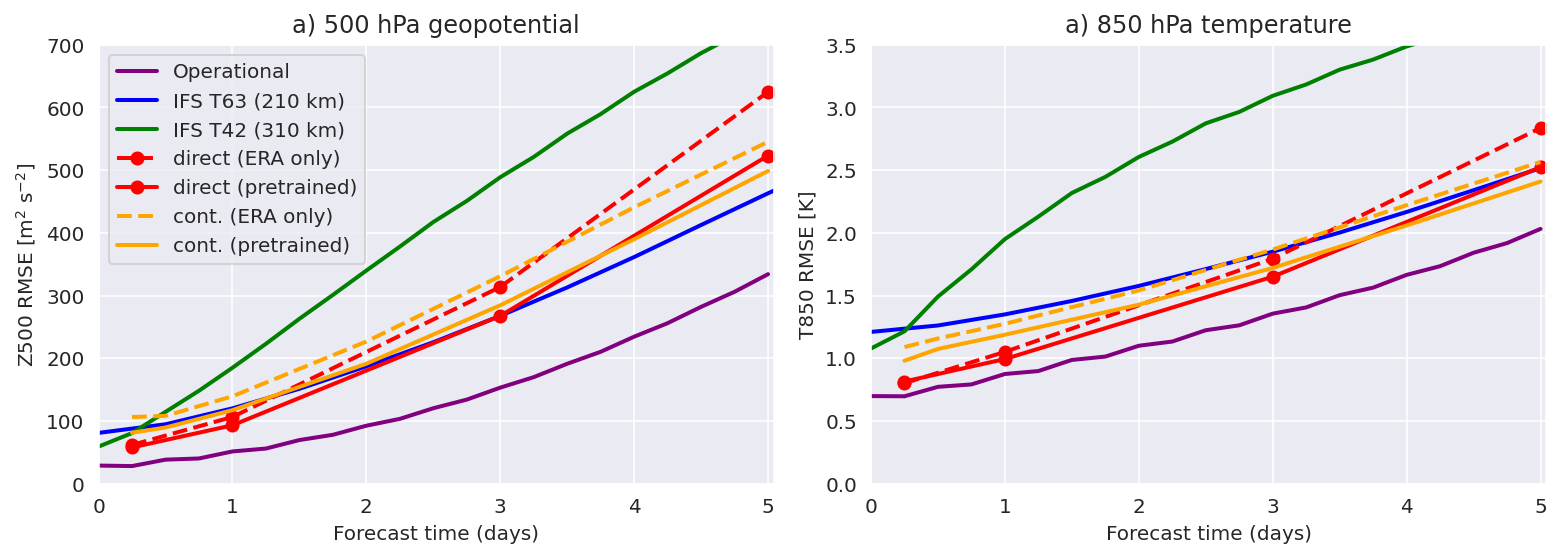

In [109]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
plot_zt(rmse_baseline['Operational'], 'Operational', c='purple')
plot_zt(rmse_baseline['IFS T63'], 'IFS T63 (210 km)', c='blue')
plot_zt(rmse_baseline['IFS T42'], 'IFS T42 (310 km)', c='green')
plot_zt(rmse_direct_era, 'direct (ERA only)', c='r', marker='o', ls='--')
# plot_zt(rmse_direct_cmip_train, 'direct (CMIP only)', c='r', marker='o', ls=':')
plot_zt(rmse_direct_pre, 'direct (pretrained)', c='r', marker='o')
plot_zt(rmse_cont_era, 'cont. (ERA only)', c='orange', ls='--')
# plot_zt(rmse_cont_cmip_train, 'cont. (CMIP only)', c='orange', ls=':')
plot_zt(rmse_cont_pre, 'cont. (pretrained)', c='orange')
# plot_zt(rmse_weyn, 'Weyn', c='yellow')
ax1.legend()
for ax in (ax1, ax2):
    ax.set_xlim(0, 121)
    ax.set_xticks([0, 24, 48, 72, 96, 120])
    ax.set_xticklabels([0, 1, 2, 3, 4, 5])
    ax.set_xlabel('Forecast time (days)')
ax1.set_ylim(0, 700)
ax1.set_title('a) 500 hPa geopotential')
ax1.set_ylabel(r'Z500 RMSE [m$^2$ s$^{-2}$]')
ax2.set_ylim(0, 3.5)
ax2.set_title('a) 850 hPa temperature')
ax2.set_ylabel(r'T850 RMSE [K]')
plt.tight_layout()

## generalization error

In [47]:
gen_direct_era = (rmse_direct_era - rmse_direct_era_train)
gen_cont_era = (rmse_cont_era - rmse_cont_era_train)
gen_direct_pre = (rmse_direct_pre - rmse_direct_pre_train)
gen_cont_pre = (rmse_cont_pre - rmse_cont_pre_train)

gen_direct_era_rel = (rmse_direct_era - rmse_direct_era_train) / (rmse_direct_era + rmse_direct_era_train) / 2
gen_cont_era_rel = (rmse_cont_era - rmse_cont_era_train) / (rmse_cont_era + rmse_cont_era_train) / 2
gen_direct_pre_rel = (rmse_direct_pre - rmse_direct_pre_train) / (rmse_direct_pre + rmse_direct_pre_train) / 2
gen_cont_pre_rel = (rmse_cont_pre - rmse_cont_pre_train) / (rmse_cont_pre + rmse_cont_pre_train) / 2

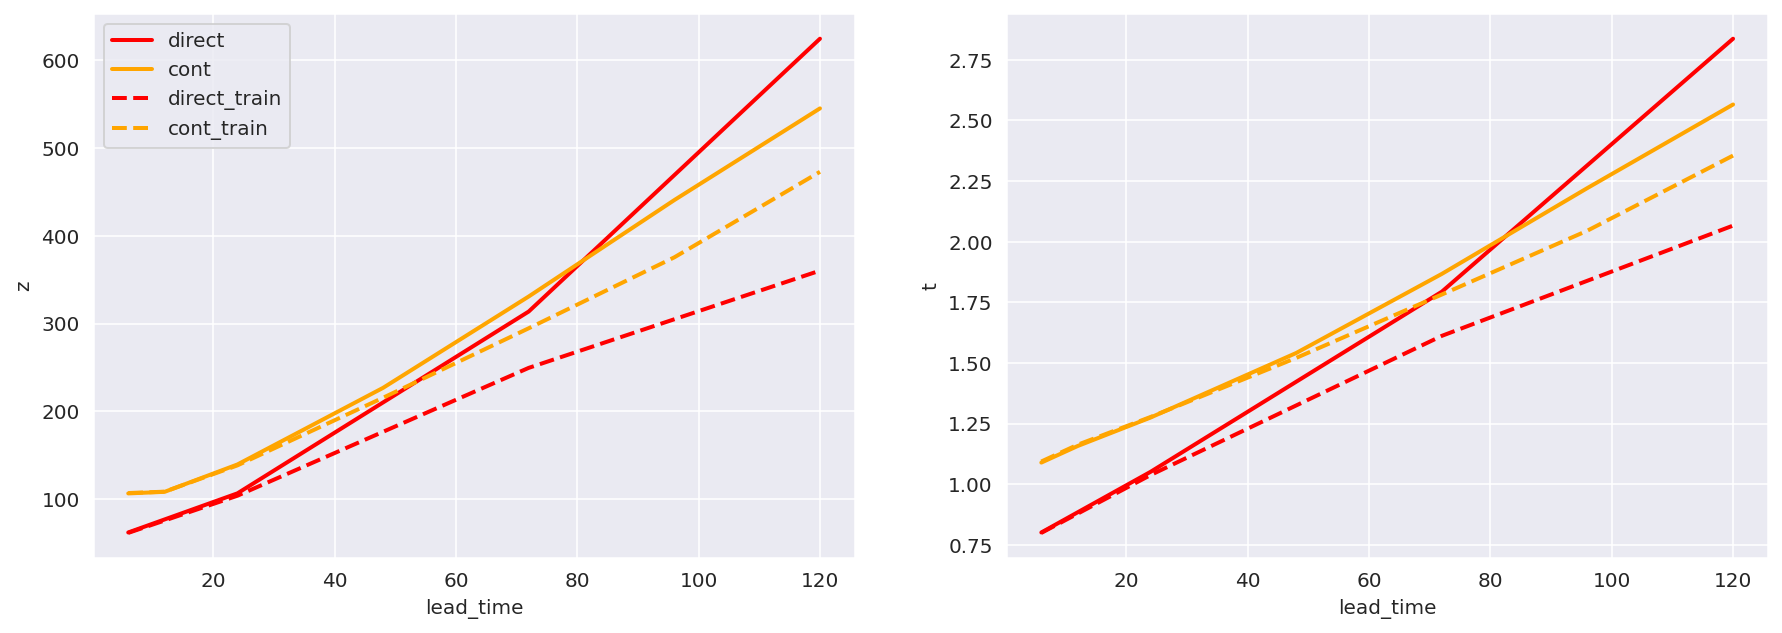

In [103]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_zt(rmse_direct_era, 'direct', c='r')
plot_zt(rmse_cont_era, 'cont', c='orange')
plot_zt(rmse_direct_era_train, 'direct_train', c='r', ls='--')
plot_zt(rmse_cont_era_train, 'cont_train', c='orange', ls='--')
ax1.legend()

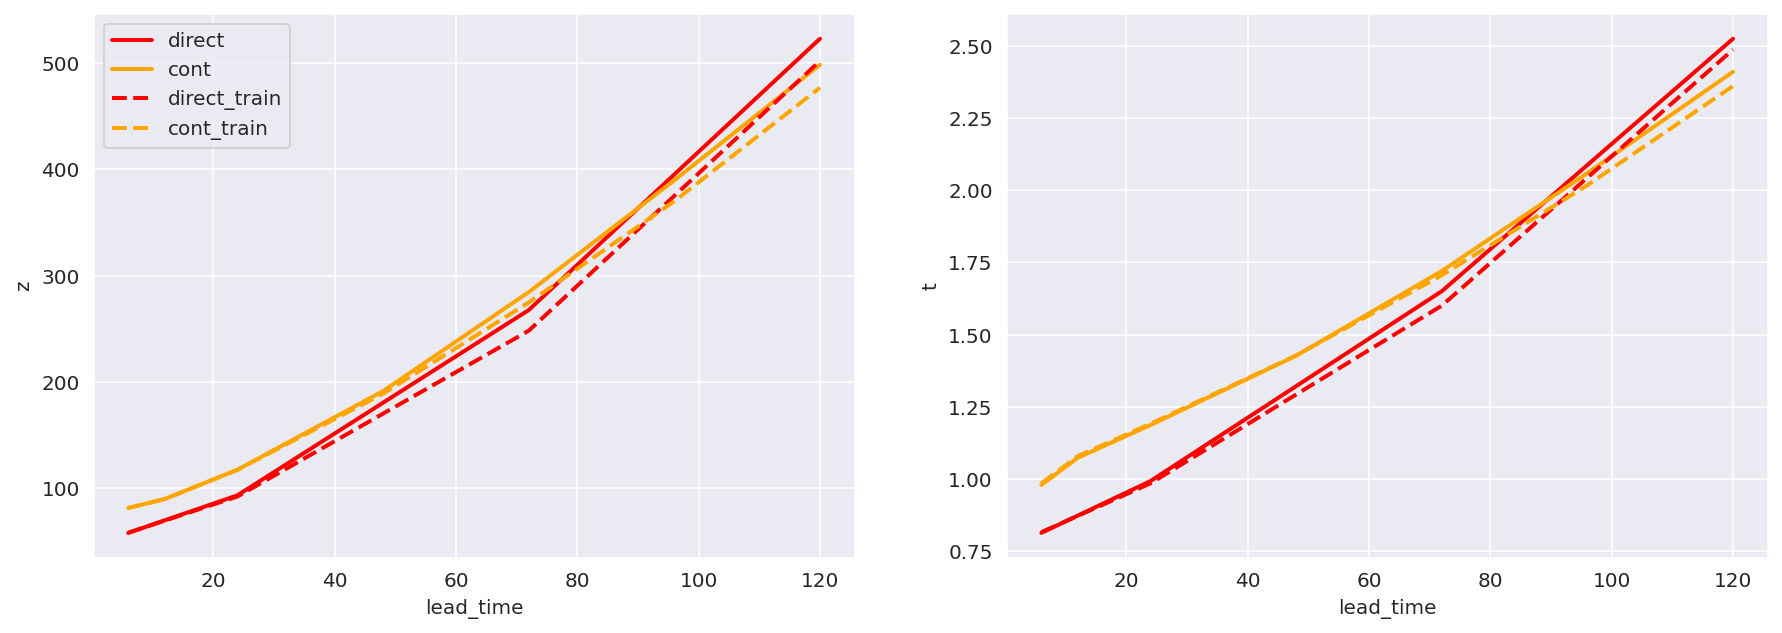

In [104]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_zt(rmse_direct_pre, 'direct', c='r')
plot_zt(rmse_cont_pre, 'cont', c='orange')
plot_zt(rmse_direct_pre_train, 'direct_train', c='r', ls='--')
plot_zt(rmse_cont_pre_train, 'cont_train', c='orange', ls='--')
ax1.legend()

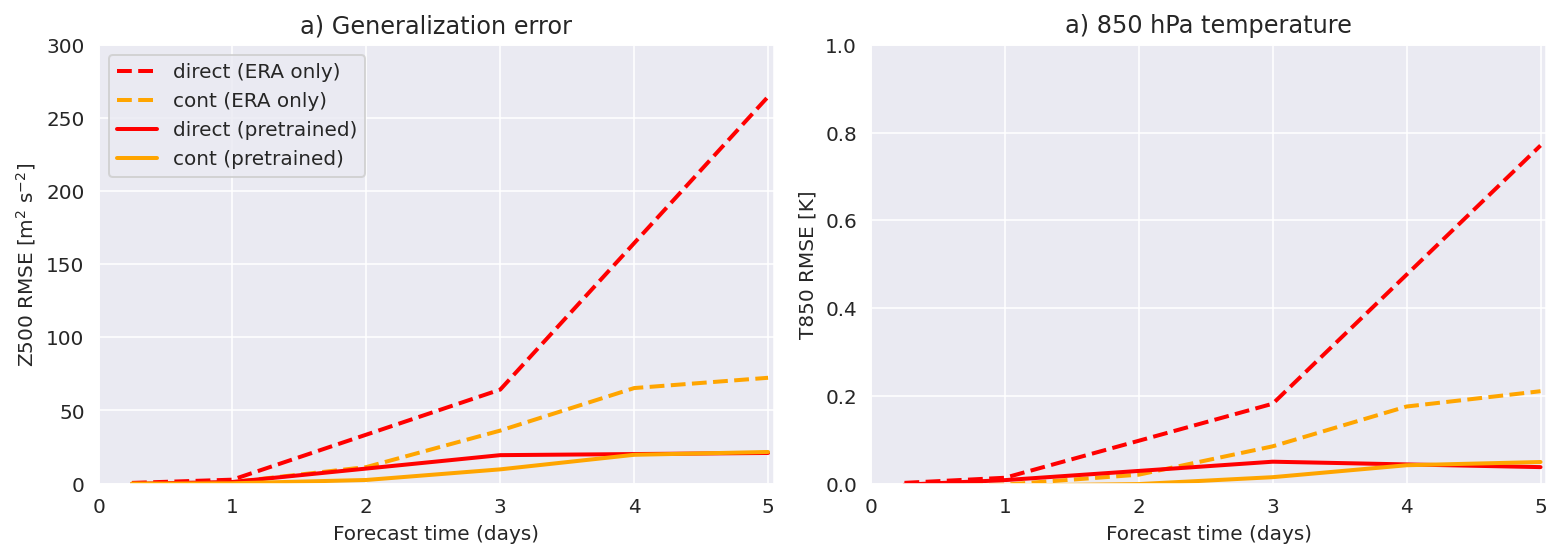

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))
plot_zt(gen_direct_era, 'direct (ERA only)', c='r', ls='--')
plot_zt(gen_cont_era, 'cont (ERA only)', c='orange', ls='--')
plot_zt(gen_direct_pre, 'direct (pretrained)', c='r')
plot_zt(gen_cont_pre, 'cont (pretrained)', c='orange')
ax1.legend()
for ax in (ax1, ax2):
    ax.set_xlim(0, 121)
    ax.set_xticks([0, 24, 48, 72, 96, 120])
    ax.set_xticklabels([0, 1, 2, 3, 4, 5])
    ax.set_xlabel('Forecast time (days)')
ax1.set_ylim(0, 300)
ax1.set_title('a) Generalization error')
ax1.set_ylabel(r'Z500 RMSE [m$^2$ s$^{-2}$]')
ax2.set_ylim(0, 1)
ax2.set_title('a) 850 hPa temperature')
ax2.set_ylabel(r'T850 RMSE [K]')
plt.tight_layout()

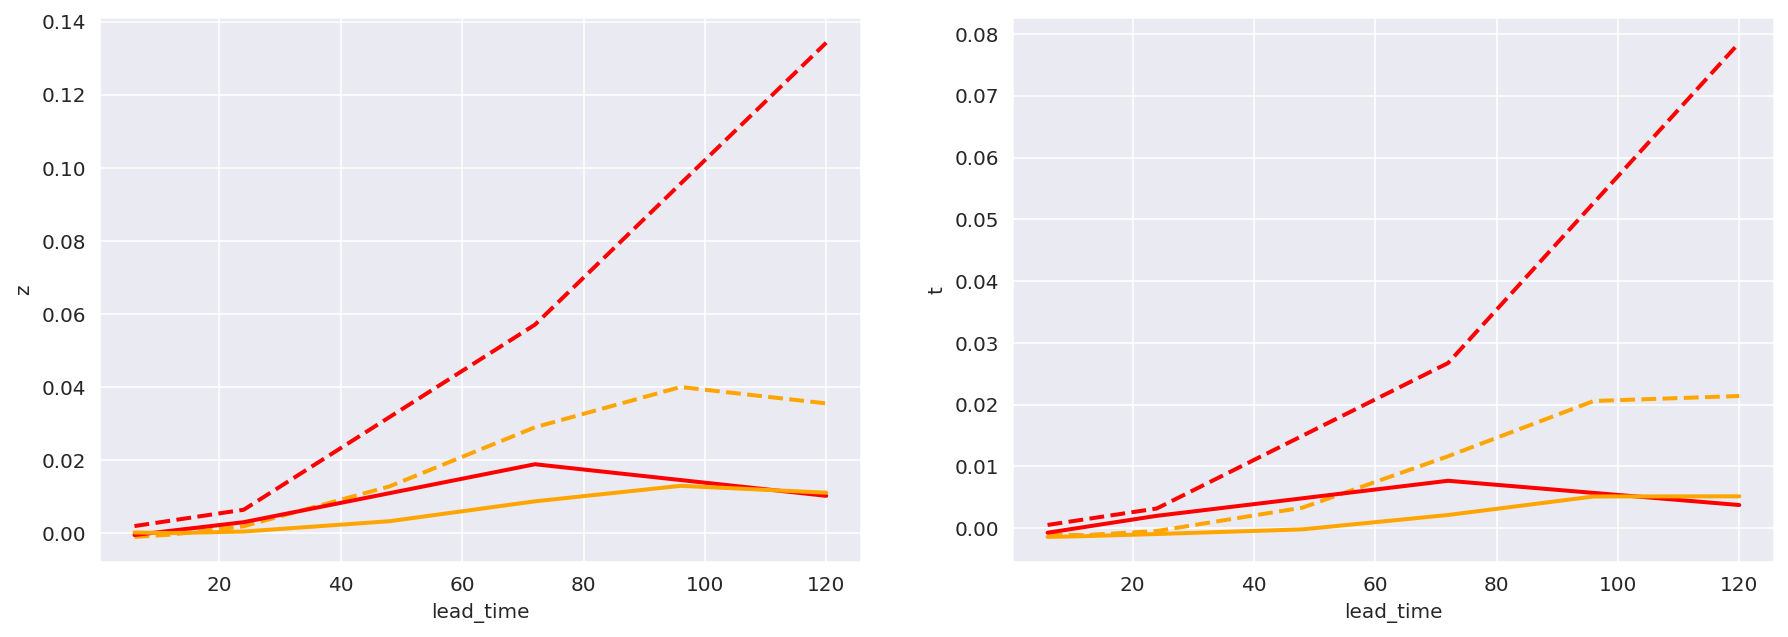

In [106]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
plot_zt(gen_direct_era_rel, 'direct era', c='r', ls='--')
plot_zt(gen_cont_era_rel, 'cont_era', c='orange', ls='--')
plot_zt(gen_direct_pre_rel, 'direct pre', c='r')
plot_zt(gen_cont_pre_rel, 'cont_pre', c='orange')

## Pretraining evaluation

### Direct 

In [10]:
cmip = ['123-resnet_d3_1d_cmip', '125-resnet_d3_3d_cmip', '127-resnet_d3_5d_cmip']
era = ['130-resnet_d3_1d_pre_cmip', '131-resnet_d3_3d_pre_cmip', '132-resnet_d3_5d_pre_cmip']
cmip_scores = []; era_scores = []
for c, e in tqdm(zip(cmip, era)):
    args_cmip = load_args(f'../nn_configs/B/{c}.yml')
    args_era = load_args(f'../nn_configs/B/{e}.yml')
    model_cmip = load_model(args_cmip)
    model_era = load_model(args_era)
    dg_test = load_data(**args_era, only_test=True)
    preds_cmip = create_predictions(model_cmip, dg_test)
    preds_era = create_predictions(model_era, dg_test)
    cmip_scores.append(compute_weighted_rmse(preds_cmip, valid).compute())
    era_scores.append(compute_weighted_rmse(preds_era, valid).compute())

In [12]:
cmip2 = ['145-resnet_d3_5d_cmip2']
era2 = ['149-resnet_d3_5d_pre_cmip2']
cmip_scores2 = []; era_scores2 = []
for c, e in tqdm(zip(cmip2, era2)):
    args_cmip = load_args(f'../nn_configs/B/{c}.yml')
    args_era = load_args(f'../nn_configs/B/{e}.yml')
    model_cmip = load_model(args_cmip)
    model_era = load_model(args_era)
    dg_test = load_data(**args_era, only_test=True)
    preds_cmip = create_predictions(model_cmip, dg_test)
    preds_era = create_predictions(model_era, dg_test)
    cmip_scores2.append(compute_weighted_rmse(preds_cmip, valid).compute())
    era_scores2.append(compute_weighted_rmse(preds_era, valid).compute())

In [23]:
cmip3 = ['134-resnet_no_dr_3d_cmip']
era3 = ['135-resnet_no_dr_3d_pre_cmip']
cmip_scores3 = []; era_scores3 = []
for c, e in tqdm(zip(cmip3, era3)):
    args_cmip = load_args(f'../nn_configs/B/{c}.yml')
    args_era = load_args(f'../nn_configs/B/{e}.yml')
    model_cmip = load_model(args_cmip)
    model_era = load_model(args_era)
    dg_test = load_data(**args_era, only_test=True)
    preds_cmip = create_predictions(model_cmip, dg_test)
    preds_era = create_predictions(model_era, dg_test)
    cmip_scores3.append(compute_weighted_rmse(preds_cmip, valid).compute())
    era_scores3.append(compute_weighted_rmse(preds_era, valid).compute())

In [19]:
cmip_scores

[<xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 173.0
     t        float64 1.333,
 <xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 326.2
     t        float64 2.015,
 <xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 535.1
     t        float64 2.703]

In [20]:
era_scores

[<xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 91.1
     t        float64 0.9958,
 <xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 274.6
     t        float64 1.682,
 <xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 506.2
     t        float64 2.452]

In [21]:
cmip_scores2

[<xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 573.9
     t        float64 2.835]

In [22]:
era_scores2

[<xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 519.7
     t        float64 2.521]

In [24]:
cmip_scores3

[<xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 309.3
     t        float64 1.961]

In [25]:
era_scores3

[<xarray.Dataset>
 Dimensions:  ()
 Data variables:
     z        float64 262.8
     t        float64 1.641]

In [26]:
X, y = dg_test[0]

In [27]:
X.shape

(32, 32, 64, 108)

In [29]:
(5*7+3)*3

114

## C all vs zt

In [115]:
tp = xr.open_mfdataset(f'{args["datadir"]}/6hr_precipitation/*.nc',combine='by_coords').sel(time=slice('2014', '2018', None))
t2m = xr.open_mfdataset(f'{args["datadir"]}/2m_temperature/*.nc',combine='by_coords').sel(time=slice('2014', '2018', None))
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z', years=slice('2014', '2018', None)).drop('level')
t850_valid = load_test_data(f'{valdir}temperature_850', 't', years=slice('2014', '2018', None)).drop('level')

In [116]:
valid2 = xr.merge([z500_valid, t850_valid, tp, t2m])

In [118]:
valid2=valid2.isel(time=slice(0, None, 12))

In [119]:
valid2

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 3652)
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 2014-01-01 ... 2018-12-31T12:00:00
Data variables:
    z        (time, lat, lon) float32 dask.array<chunksize=(730, 32, 64), meta=np.ndarray>
    t        (time, lat, lon) float32 dask.array<chunksize=(730, 32, 64), meta=np.ndarray>
    tp       (time, lat, lon) float32 dask.array<chunksize=(730, 32, 64), meta=np.ndarray>
    t2m      (time, lat, lon) float32 dask.array<chunksize=(730, 32, 64), meta=np.ndarray>

In [103]:
args = load_args('../nn_configs/C/001-resnet_d3_all_3d.yml')

In [104]:
dg_test = load_data(**args, only_test=True)

In [105]:
model = load_model(args)

In [106]:
preds = create_predictions(model, dg_test)

In [107]:
preds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17436)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    tp       (time, lat, lon) float64 2.168e-19 2.168e-19 ... 0.0001333 0.000116
    t        (time, lat, lon) float64 256.4 256.5 256.5 ... 249.8 249.7 249.4
    z        (time, lat, lon) float64 5.055e+04 5.052e+04 ... 4.91e+04 4.908e+04
    t2m      (time, lat, lon) float64 247.0 246.9 246.7 ... 249.0 248.6 247.9

In [108]:
compute_weighted_rmse(preds, valid2).load()

/home/rasp/miniconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


<xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float64 nan
    t        float64 2.002
    z        float64 355.2
    t2m      float64 nan

In [120]:
args = load_args('../nn_configs/C/002-resnet_d3_all_3d_tfr.yml')

In [121]:
dg_train, dg_valid, dg_test = load_data(**args)

DG start 10:22:12.374400
DG normalize 10:22:12.419459
DG load 10:22:12.427545
DG done 10:22:12.427587


In [122]:
model = load_model(args)

In [123]:
preds = create_predictions(model, dg_test)

In [124]:
compute_weighted_rmse(preds, valid2).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    tp       float64 0.002203
    t        float64 1.985
    z        float64 349.0
    t2m      float64 1.766

In [125]:
args = load_args('../nn_configs/C/003-resnet_d3_zt_3d.yml')

In [126]:
dg_train, dg_valid, dg_test = load_data(**args)

DG start 10:23:03.285211
DG normalize 10:23:03.330763
DG load 10:23:03.338740
DG done 10:23:03.338792


In [127]:
model = load_model(args)

In [128]:
preds = create_predictions(model, dg_test)

In [129]:
compute_weighted_rmse(preds, valid2).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t        float64 1.818
    z        float64 313.9

In [42]:
preds = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_C/013-resnet_d3_zt_3d_pre.nc')

In [44]:
compute_weighted_rmse(preds, valid).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 296.4
    t        float64 1.751

## 11/22 deg

### Saved test scores

In [57]:
rmse_11_pre = compute_weighted_rmse(
    xr.open_dataset(f'{preddir}/064-resnet_d3_ztt_3d_11deg_pre.nc'),
    valid
).load()
rmse_22_pre = compute_weighted_rmse(
    xr.open_dataset(f'{preddir}/065-resnet_d3_ztt_3d_22deg_pre.nc'),
    valid
).load()

In [111]:
args = load_args('../nn_configs/C/065-resnet_d3_ztt_3d_22deg_pre.yml')
dg_test = load_data(**args, only_test=True)
model = load_model(args)

In [112]:
preds22 = create_predictions(model, dg_test)

In [113]:
valid_22 = regrid(valid, 22.5)

Reuse existing file: bilinear_32x64_8x16_peri.nc
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.


/home/rasp/miniconda3/lib/python3.7/site-packages/xesmf/smm.py:70: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not C_CONTIGUOUS. "


In [118]:
rr22 = compute_weighted_rmse(preds22, valid_22); rr22

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 432.2
    t2m      float64 1.526
    t        float64 1.978

In [119]:
args = load_args('../nn_configs/C/064-resnet_d3_ztt_3d_11deg_pre.yml')
dg_test = load_data(**args, only_test=True)
model = load_model(args)

In [120]:
preds11 = create_predictions(model, dg_test)

In [121]:
preds11 = regrid(preds11, 22.5)

Create weight file: bilinear_16x32_8x16_peri.nc
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z as the horizontal dimensions for this dataset.
using dimensions ('lat', 'lon') from data variable z

In [122]:
rr11 = compute_weighted_rmse(preds11, valid_22); rr11

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 362.9
    t2m      float64 2.344
    t        float64 1.846

In [124]:
rr5

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 1.151
    t        float64 1.427
    z        float64 284.6

In [58]:
rmse_11_era = compute_weighted_rmse(
    xr.open_dataset(f'{preddir}/060-resnet_d3_ztt_3d_11deg.nc'),
    valid
).load()
rmse_22_era = compute_weighted_rmse(
    xr.open_dataset(f'{preddir}/061-resnet_d3_ztt_3d_22deg.nc'),
    valid
).load()

In [63]:
rmse_direct_pre.sel(concat_dim=72).z.values, rmse_direct_era.sel(concat_dim=72).z.values

(array(267.55041697), array(313.67628498))

In [60]:
rmse_11_pre.z.values, rmse_11_era.z.values

(array(403.3908897), array(427.84309833))

In [61]:
rmse_22_pre.z.values, rmse_22_era.z.values

(array(677.22360515), array(687.59898781))

In [64]:
np.array([
    [rmse_direct_era.sel(concat_dim=72).z.values, rmse_direct_pre.sel(concat_dim=72).z.values],
    [rmse_11_era.z.values, rmse_11_pre.z.values],
    [rmse_22_era.z.values, rmse_22_pre.z.values]
])

array([[313.67628498, 267.55041697],
       [427.84309833, 403.3908897 ],
       [687.59898781, 677.22360515]])

In [67]:
df = pd.DataFrame(
    data = np.array([
    [rmse_direct_era.sel(concat_dim=72).z.values, rmse_direct_pre.sel(concat_dim=72).z.values],
    [rmse_11_era.z.values, rmse_11_pre.z.values],
    [rmse_22_era.z.values, rmse_22_pre.z.values]
]),
    index=['5.625', '11.25', '22.5'], columns=['ERA only', 'pretrained']
)

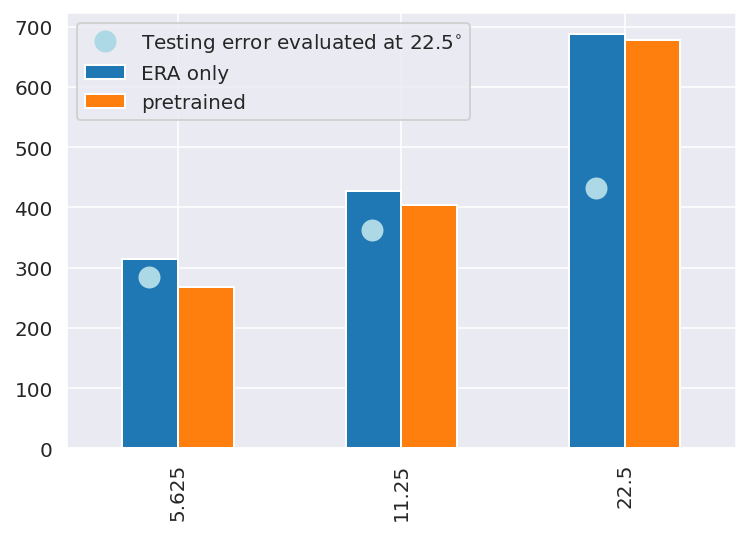

In [140]:
df.plot.bar()
plt.plot([-0.13, 0.87, 1.87], [rr5.z.values, rr11.z.values, rr22.z.values], c='lightblue', lw=0, marker='.', markersize=20,
         label=r'Testing error evaluated at 22.5$^{\circ}$')
plt.legend()

In [23]:
preds = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions/81-resnet_d3_dr_0.1_fixed.nc')

In [24]:
rmse5 = compute_weighted_rmse(preds, valid).compute()

In [30]:
rmse11

<xarray.Dataset>
Dimensions:  (time: 1453)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T12:00:00
Data variables:
    t        (time) float64 2.367 2.424 2.571 2.563 ... 2.268 2.409 2.318 2.379
    z        (time) float64 432.3 446.4 457.9 449.1 ... 387.8 388.9 394.9 402.7

In [35]:
rmse = xr.concat([rmse5, rmse11, rmse22], dim=[5.625, 11.25, 22.5])

In [36]:
rmse

<xarray.Dataset>
Dimensions:     (concat_dim: 3)
Coordinates:
  * concat_dim  (concat_dim) float64 5.625 11.25 22.5
Data variables:
    z           (concat_dim) float64 314.2 424.1 687.8
    t           (concat_dim) float64 1.823 2.391 3.337

In [40]:
rmse_pre = [280, 407, 684]

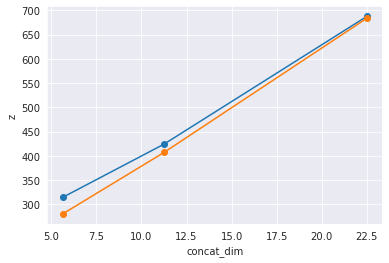

In [41]:
rmse.z.plot(marker='o')
plt.plot([5.625, 11.25, 22.5], rmse_pre, marker='o')

## Variability

In [73]:
preds_6h = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_C/026-resnet_d3_ztt_6h_pre_no_dr.nc')
preds_1d = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_C/031-resnet_d3_ztt_1d_pre_no_dr.nc')
preds_3d = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_C/023-resnet_d3_ztt_3d_pre_no_dr.nc')
preds_5d = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_C/034-resnet_d3_ztt_5d_pre_no_dr.nc')

In [80]:
import matplotlib

In [91]:
cmap = matplotlib.cm.get_cmap('YlOrRd')
colors = cmap(np.linspace(0.3, 1, 4))

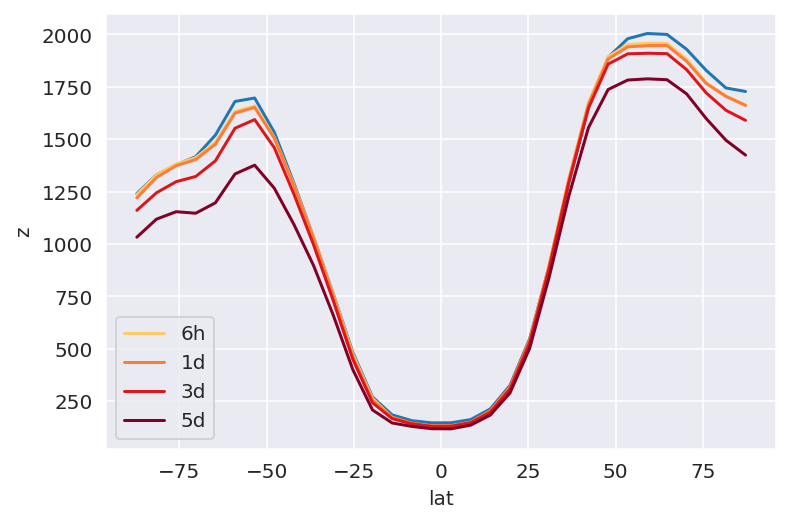

In [108]:
valid.z.std(('lon', 'time')).plot()
preds_6h.z.isel(time=slice(0, None, 12)).std(('lon', 'time')).plot(c=colors[0], label='6h')
preds_1d.z.isel(time=slice(0, None, 12)).std(('lon', 'time')).plot(c=colors[1], label='1d')
preds_3d.z.isel(time=slice(0, None, 12)).std(('lon', 'time')).plot(c=colors[2], label='3d')
preds_5d.z.isel(time=slice(0, None, 12)).std(('lon', 'time')).plot(c=colors[3], label='5d')
plt.legend()

## Example plots

In [96]:
time = '2018-01-01T00'

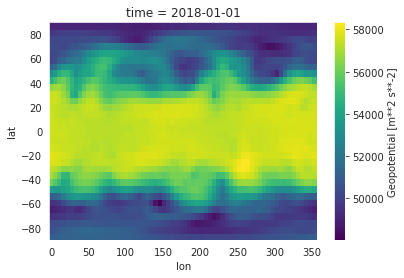

In [98]:
valid.z.sel(time=time).plot()

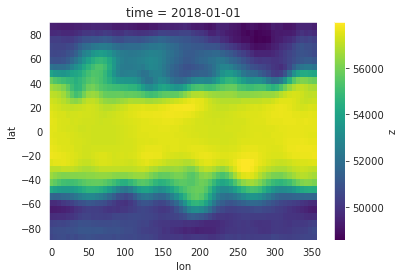

In [99]:
preds_5d.z.sel(time=time).plot()

## Fluctuations

In [8]:
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z', years=slice('1979', '2018', None)).drop('level')
t850_valid = load_test_data(f'{valdir}temperature_850', 't', years=slice('1979', '2018', None)).drop('level')
valid = xr.merge([z500_valid, t850_valid])

In [9]:
valid = valid.isel(time=slice(0, None, 12))

In [10]:
clim = valid.mean('time')

In [11]:
rmse = compute_weighted_rmse(clim, valid, ['lat', 'lon']).load()

In [16]:
rmse_y = rmse.groupby('time.year').mean()

In [21]:
rel = rmse_y / rmse_y.mean('year')

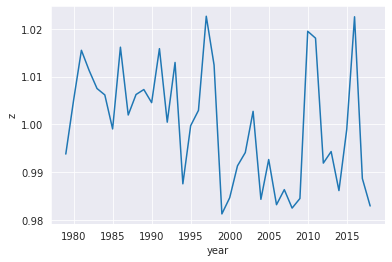

In [22]:
rel.z.plot()

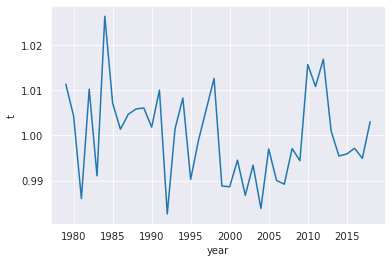

In [23]:
rel.t.plot()

## TP

In [42]:
args = load_args('../nn_configs/C/019-resnet_d3_tp_3d_pre.yml')

In [44]:
dg_test = load_data(**args, only_test=True)

In [45]:
model = load_model(args)

In [47]:
preds = create_predictions(model, dg_test)

ValueError: conflicting sizes for dimension 'level': length 1 on the data but length 4 on coordinate 'level'

In [48]:
%debug

> /home/rasp/miniconda3/lib/python3.7/site-packages/xarray/core/dataarray.py(154)_infer_coords_and_dims()
    152                     "conflicting sizes for dimension %r: "
    153                     "length %s on the data but length %s on "
--> 154                     "coordinate %r" % (d, sizes[d], s, k)
    155                 )
    156 

ipdb> u
> /home/rasp/miniconda3/lib/python3.7/site-packages/xarray/core/dataarray.py(343)__init__()
    341             data = _check_data_shape(data, coords, dims)
    342             data = as_compatible_data(data)
--> 343             coords, dims = _infer_coords_and_dims(data.shape, coords, dims)
    344             variable = Variable(dims, data, attrs, fastpath=True)
    345             indexes = dict(

ipdb> u
> /home/rasp/repositories/myWeatherBench/devlog/src/data_generator.py(456)create_predictions()
    454         coords={'time': dg.valid_time, 'lat': dg.data.lat, 'lon': dg.data.lon,
    455                 'level': level,
--> 456      

## Difference

In [71]:
z500_valid = load_test_data(f'{valdir}geopotential_500', 'z', years=slice('2017', '2018', None)).drop('level')
t850_valid = load_test_data(f'{valdir}temperature_850', 't', years=slice('2017', '2018', None)).drop('level')
t2m_valid = xr.open_mfdataset(f'{valdir}2m_temperature/*.nc').sel(time=slice('2017', '2018', None))
valid = xr.merge([z500_valid, t850_valid, t2m_valid]).load()

In [49]:
args = load_args('../nn_configs/C/027-resnet_d3_ztt_3d_diff.yml')

In [51]:
args['ext_mean'] = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_mean.nc")
args['ext_std'] = xr.open_dataarray(f"{args['model_save_dir']}/{args['exp_id']}_std.nc")

In [52]:
dg_test = load_data(**args, only_test=True)

In [56]:
X, y = dg_test[0]

In [53]:
model = load_model(args)

In [109]:
valid.sel(time=dg_test.init_time).assign_coords(time=dg_test.valid_time)

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17436)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-04T12:00:00 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 50939.312 50954.625 ... 49110.83 49057.234
    t        (time, lat, lon) float32 257.2241 257.20108 ... 255.42131 255.75526
    t2m      (time, lat, lon) float32 248.61656 248.18849 ... 253.59349

In [110]:
pp = valid.sel(time=dg_test.init_time).assign_coords(time=dg_test.valid_time) + preds

In [111]:
compute_weighted_rmse(pp, valid.isel(time=slice(0, None, 12))).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    z        float64 315.2
    t        float64 1.812
    t2m      float64 1.533